# Grover's search algorithm

Grover's search is a quantum algorithm for unstructered database search in a database with N entries. It was invented by Lov Kumar Grover and published in 1996. Grover's search requires an order of $\mathcal{O}(\sqrt{N})$ operations, while the best possible classical algorithm scales with $\mathcal{O}(N)$. Therefore for large N, the algorithm outperforms classical algorithms severely.

This Jupyter Notebook aims to showcase how Grover's search can be implemented on a quantum computer and how it can be utilized on general problems. 

The orginal paper from Grover is "A fast quantum mechanical algorithm for database search":arXiv:quant-ph/9605043

For further reading, consult the qiskit-textbook: https://qiskit.org/textbook/ch-algorithms/grover.html

### Initialize

First we have to initialize a few libraries that will be used in the notebook.

In [1]:
# qiskit
from qiskit import QuantumRegister, ClassicalRegister # Registers
from qiskit import QuantumCircuit, execute, Aer # Circuit, execution and simulator
from qiskit import IBMQ # base library
from qiskit.visualization import plot_histogram # plot histogram
from qiskit.providers.ibmq import least_busy # check least busy quantum computer
from qiskit.tools import backend_monitor,backend_overview # useful tools for backend overview and analysis

# other
import numpy as np # numpy (base math functions)
import math # floor function
import matplotlib.pyplot as plt # plotting

# load provider
provider = IBMQ.load_account() # loading account

C:\Users\neply\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# Solving 3x3 grid problem with Grover's search

## Describing the problem

Here, Grover's search algorithm will be demonstrated on the following problem:

We have a 4x2 grid and each tile contains a bit $q_{i}$ $ i\in \{0,1,2,...,7,8\}$, which can be either 1 or 0. <br>
There are rules enforced on the system, implemented in the form of XOR on pairs of bits  $(q_{i},q_{j})$, with $q_{i}\neq q_{j}$. <br>
The task of Grover's algorithm is to find all bit configurations $(q_{0},q_{1},q_{2},...,q_{8})$, so that all rules are fulfilled.


<br> Other rules (OR,AND,NAND) can also be implemented relatively easily in a similar fashion, but may require additional ancilla qubits.


<img src="images/4x2_grid.jpg" width="300" height="400">

## Implementing grover's search

First, the rules have to be definded. Each pair $[i,j]$ in the clauses-array defines, which two bits are connected by a XOR-gate.

In [54]:
# define clauses for solving the problem
clauses=[[0,1],[1,2] , [3,4],[4,5] , [6,7],[7,8],   [2,5],[5,8]]

Now the rules have to be implemented in a circuit. A XOR-quantum gate can be implemented as follows:

<img src="images/XOR_gate.png" width="300" height="400">

The qubit $q_{2}$ is an ancilla qubit and will be preapred in the state $| 0 \rangle$. <br> It will be the logical output of our XOR operation. $q_{0}$ and $q_{1}$ represent the input of the XOR gate.

In [55]:
# XOR-gate
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

Now the Oracle operator $U_w$ will be constructed. It attaches a negative sign to all states that correspond to solutions. It can be implemented as follows:

<img src="images/oracle_gate.png" width="1000" height="400">

The $a_j$ denote ancilla qubits that are used to perform XOR-operations. The $out_0$ qubit is initialized in a $| -\rangle$ state. The Toffoli-gate attaches a negative sign to it only, if all ancilla qubits are in state $| 1 \rangle$ (which means all conditions are fullfilled). Due to the linearity of the tensor product, a given composite state only receives a negative sign, if it is a solution to the problem. Therefore the orcale is implemented.


In [56]:
def clause_oracle(nr_var_qubits, clauses, clause_qubits):
    var_qubits = QuantumRegister(nr_var_qubits, name='q')  # variable bits
    clause_qubits = QuantumRegister(len(clauses), name='a')  # bits to store clause-checks
    output_qubit = QuantumRegister(1, name='out')
    qc_orac=QuantumCircuit(var_qubits, clause_qubits, output_qubit)
    # Use XOR gate to check each clause
    i = 0
    for clause in clauses:
        XOR(qc_orac, clause[0], clause[1], clause_qubits[i])
        i += 1
    # Flip 'output' bit if all clauses are satisfied
    qc_orac.mct(clause_qubits, output_qubit)

    # Uncompute operation to reset qubits for following iterations
    i = 0
    for clause in clauses:
        XOR(qc_orac, clause[0], clause[1], clause_qubits[i])
        i += 1
    U_w = qc_orac.to_gate()
    U_w.name = "U$_w$"
    return U_w

Next, the Grover diffusion operator $U_s$ will be implemented:

<img src="images/diffuser_gate.png" width="500" height="400">

Here it is implemented for general N qubits.

In [57]:
# nqubit diffuser
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1, mode='noancilla')  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

# Complete algorithm

Now that all parts are given, grover's algorithm can be implemented. 

Note, that for the amount of iterations m is given by: $m=\left \lfloor{   \frac{\pi}{4}\sqrt{\frac{N}{l}}  }\right \rfloor  +\mathcal{O} (\frac{l}{N})$, with $N=2^{n}$ as the amount of states (n the amount of qubits encoding the database) <br> and l as the amount of expected solutions for the query. Therefore it can be well approximated with this formula for $\frac{l}{N}$ large. 

If that is not the case, the exact formula is $m=\left \lfloor{ \frac{cos^{-1}(\sqrt{\frac{N}{l}})}{sin^{-1}(\frac{2 \sqrt{l(N-l)}}{N})  }}\right \rfloor$

The derivation can be found in the paper "Grover's Algorithm for Multiobject Search in Quantum Computing": arXiv:quant-ph/9909040

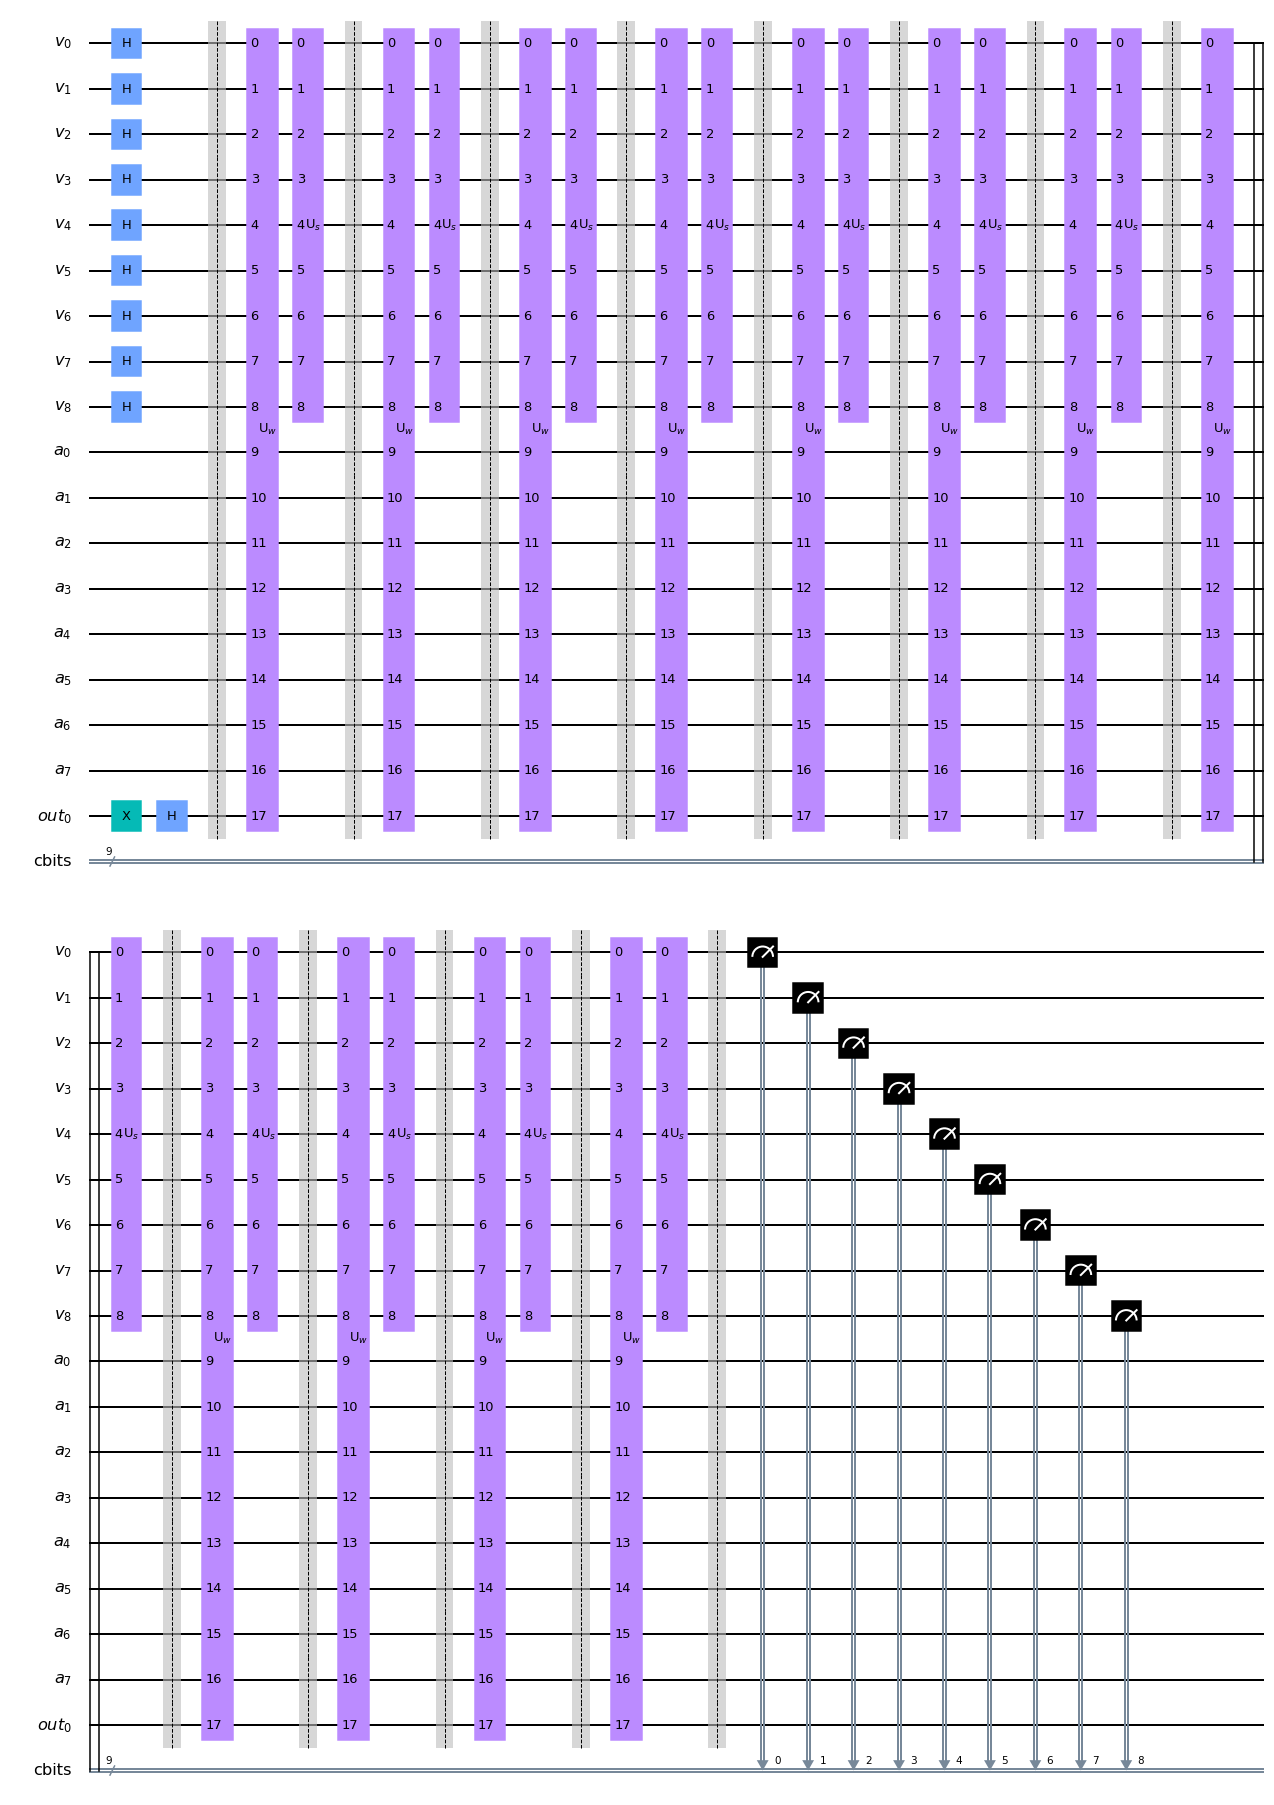

In [58]:
# Calculate Nr. of iterations
exp_results=2**(9-len(clauses)) # Nr. of expected results
iterations=math.floor(np.pi/4*np.sqrt(2**9/exp_results)) # Nr. of iterations

# Create separate registers to name bits
var_qubits = QuantumRegister(9, name='v')  # variable bits
clause_qubits = QuantumRegister(len(clauses), name='a')  # bits to store clause-checks
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(9, name='cbits')

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)
# initialize s-state
qc.h(var_qubits)
# Initialise 'out0' in state |->
qc.x(output_qubit)
qc.h(output_qubit)
#qc.initialize([1, -1]/np.sqrt(2), output_qubit) # alternative way of initialization
qc.barrier()

for i in range(iterations):
    # Apply our oracle
    qc.append(clause_oracle(9, clauses, clause_qubits),list(range(9+len(clauses)+1)))
    # Apply our diffuser
    qc.append(diffuser(9), list(range(9)))
    qc.barrier()

# Measure the variable qubits
qc.measure(var_qubits, cbits)
    
    
qc.draw("mpl")

Now that the circuit is created, it's results will be simulated with the "qasm_simulator".

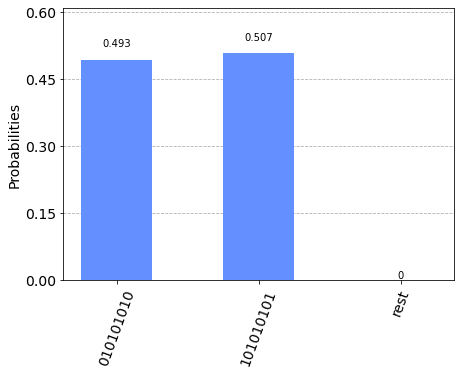

In [59]:
# Simulate and plot results
# number to keep
ntk=8
# # # # # # # # #
qasm_simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, backend=qasm_simulator, shots=1024).result()
plot_histogram(result.get_counts(),number_to_keep=ntk)

The states with significantly larger occurance in the histrogram than the other N states should be our solutions. Below it will be checked, if they actually are solutions.

## plot results

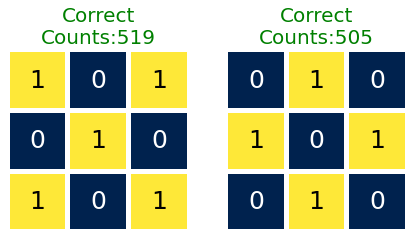

In [61]:
results=sorted(result.get_counts().items(), key=lambda item: item[1])[::-1][:ntk] # ntk results
threshold=0.05 # define threshold for what results to plot
solutions=[results[i]for i in range(len(results))  if results[i][1]>=threshold*1024]
#all data
rows=int(len(solutions) / 4) + (len(solutions) % 4 > 0) # how many rows
# plot
fig = plt.figure(figsize=(15, 5*rows))
for i,sol in enumerate(solutions):
    ax=plt.subplot(rows,4,i+1)
    ax.set_axis_off() # hide axis
    bitstring=list(map(int, sol[0]))
    # check if clauses are fulfilled
    clause_status="Correct"
    clause_color="green"
    for clause in clauses:
        if bitstring[clause[0]]==bitstring[clause[1]]:
            clause_status="Incorrect"
            clause_color="red"
    
    
    image=np.reshape(bitstring,(3,3))
    ax.pcolormesh(image, edgecolors='white', linewidth=4,cmap="cividis")
    ax.set_aspect('equal')
    
    for (j,i),label in np.ndenumerate(image):
        if label==1:
            ax.text(i+0.5,j+0.5,label,ha='center',va='center',color="black",fontsize=25) 
        else:
            ax.text(i+0.5,j+0.5,label,ha='center',va='center',color="white",fontsize=25) 
    ax.set_title("{}\nCounts:{}".format(clause_status,sol[1]),fontsize=20, color=clause_color)

As can be seen, the results are correct solutions that indeed solve the problem. Grover's search therefore works

## On real device [Hardware not available :'(    ]

This code would run, however the available hardware makes very difficult. It could theoretically be run with the backend "ibmq_16_melbourne" for up to 7 elements ("conditions") in the "clauses"-array, but the Toffoli-gate (gate mct" is not supported as an instruction. Therefore, a 8-dimensional Toffoli gate would have to be implemented out of single- and double-qubit-gates. Implementation can be done, however it exceeds the scope of this tutorial.

The implementation of a Toffoli gate for an arbitrary amount of qubits can be implemented without additional ancilla-qubits, using the insights from the paper "Linear-Depth Quantum Circuits for n-qubit Toffoli gates with no Ancilla": arXiv:1303.3557 

In [1]:
provider = IBMQ.load_account()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 8+len(clauses)+1 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

NameError: name 'IBMQ' is not defined

In [ ]:
backend_overview()

In [ ]:
backend_monitor(backend)

In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue. This can take a while
from qiskit.tools.monitor import job_monitor
job = execute(qc, backend=backend, shots=1024, optimization_level=3)
job_monitor(job, interval = 6)

In [ ]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(qc)
plot_histogram(answer)

## References

1. Grover, Lov K. "A fast quantum mechanical algorithm for database search." Proceedings of the twenty-eighth annual ACM symposium on Theory of computing. 1996. : https://arxiv.org/abs/quant-ph/9605043

2. Qiskit-Textbook, chapter 3.10: https://qiskit.org/textbook/ch-algorithms/grover.html

3. Chen, Goong, et al. "Grover’s algorithm for multiobject search in quantum computing." Directions in Quantum Optics. Springer, Berlin, Heidelberg, 2001. 165-175. : https://arxiv.org/abs/quant-ph/9909040

4. Saeedi, Mehdi, and Massoud Pedram. "Linear-depth quantum circuits for n-qubit Toffoli gates with no ancilla." Physical Review A 87.6 (2013): 062318. : https://arxiv.org/abs/1303.3557